In [55]:
import numpy as np
from scipy import stats
from scipy import signal
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os.path import sep
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy.special import i0
from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [56]:
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import find_stop_period_on_heading,PVA_during_stopPeriod,forwrad_speed_during_stopPeriod,bump_amplitude_during_stopPeriod,calculate_angle_difference_between_two_time_point, stopping_period_signal_decay,find_qualified_stopping_period, PVA_strength_during_stopPeriod
from fly2p_function_TQ.imaging_2p_fixed_heading_period_analysis import calculate_angle_difference_between_two_time_point,run_ANOVA_for_comparing_across_genotypes,plot_stopping_period_signal,calculate_stop_signal_in_separate_fly
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import fictrack_signal_decoding
from fly2p_function_TQ.imaging_2p_PVA_functions import calcualteBumpAmplitude ,calcualteBumpAmplitude_V2_green, calcualteBumpAmplitude_V3, calculateBumpWidth_v1,von_Mises_fitting_dff_TQ, PVA_radian_to_angle,calcualteBumpAmplitude_V4,PVAangleToRoi

In [57]:
run_vonMises_fitting = 0
stable_PVA_threshold = 67.5
genotype = 'R55G08>sytGCaMP7f'
celltype = 'delta7-syt7f'
trial_condition = 'dark'

In [128]:
#Combine all persistence files for pooled analysis and statistics 

pooled_directory = ('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/dark_cl_Ca_imaging/PENb/PENb_EB(syt)_(16_ROI_F)/dark')
count = 0
output_df_pooled = pd.DataFrame()
output_bump_amplitude_V3_pooled = pd.DataFrame()
output_bump_amplitude_V3_opposite_pooled = pd.DataFrame()
output_bump_amplitude_V4_pooled = pd.DataFrame()
output_bump_width_pooled = pd.DataFrame()
output_average_bump_width_stopping = []
output_average_bump_width_active = []
output_PVA_strength_pooled = pd.DataFrame()
output_stable_PVA_index_pooled = []
output_Angular_Speed_pooled = pd.DataFrame()
output_flytrial = []
mean_PVA_strength_per_trial_pooled = []
if run_vonMises_fitting == 1:
    output_bump_amplitude_Vonmises_pooled = pd.DataFrame()
    output_bump_width_vonMises_pooled = pd.DataFrame()
    output_vonMises_gof_r2_pooled = pd.DataFrame()
for single_df in os.listdir(pooled_directory):
    current_file = pd.read_csv(sep.join([pooled_directory, single_df]))
    #Get time info
    volume_cycle = len(current_file )
    volume_time = current_file['Time_Stamp'][1]
    volume_rate = 1/volume_time
    time_array_imaging = np.arange(volume_cycle)/volume_rate
    #Get necessary parameters
    PVA_Unwrapped_Radian = current_file['Unwrapped_Radian']
    PVA_Angle = current_file['PVA_Angle']
    PVA_Radian = current_file['PVA_Radian']
    Angular_velocity = current_file['Angular_Velocity']
    integrated_x = current_file['Integrated_x']
    PVA_strength = current_file['PVA_strength']
    Bump_amplitude = current_file['Bump_amplitude']
    Unwrapped_heading = current_file['Unwrapped_Bar_Position/Heading']
    
    dff_normalized_8_roi = np.zeros((len(current_file['dFF_Roi_1']), 8))
    dff_normalized_8_roi_shifted = np.zeros((len(current_file['dFF_Roi_1']), 8))
    for i in range(len(current_file['F_Roi_1'])):
        dff_normalized_8_roi[i,0]= current_file['dFF_Roi_1'][i]
        dff_normalized_8_roi[i,1]= current_file['dFF_Roi_2'][i]
        dff_normalized_8_roi[i,2]= current_file['dFF_Roi_3'][i]
        dff_normalized_8_roi[i,3]= current_file['dFF_Roi_4'][i]
        dff_normalized_8_roi[i,4]= current_file['dFF_Roi_5'][i]
        dff_normalized_8_roi[i,5]= current_file['dFF_Roi_6'][i]
        dff_normalized_8_roi[i,6]= current_file['dFF_Roi_7'][i]
        dff_normalized_8_roi[i,7]= current_file['dFF_Roi_8'][i]
        dff_normalized_8_roi_shifted[i,0]= current_file['dFF_Roi_5'][i]
        dff_normalized_8_roi_shifted[i,1]= current_file['dFF_Roi_6'][i]
        dff_normalized_8_roi_shifted[i,2]= current_file['dFF_Roi_7'][i]
        dff_normalized_8_roi_shifted[i,3]= current_file['dFF_Roi_8'][i]
        dff_normalized_8_roi_shifted[i,4]= current_file['dFF_Roi_1'][i]
        dff_normalized_8_roi_shifted[i,5]= current_file['dFF_Roi_2'][i]
        dff_normalized_8_roi_shifted[i,6]= current_file['dFF_Roi_3'][i]
        dff_normalized_8_roi_shifted[i,7]= current_file['dFF_Roi_4'][i]
    dff_normalized_8_roi_shifted = dff_normalized_8_roi_shifted.transpose()
    #Need no series array for function below 
    PVA_Unwrapped_Radian_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    PVA_Angle_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    PVA_Radian_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Angular_velocity_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    integrated_x_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    PVA_strength_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Bump_amplitude_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    Unwrapped_heading_no_series = np.zeros(len(current_file['Unwrapped_Radian']))
    for i in range(len(current_file['Unwrapped_Radian'])):
        PVA_Unwrapped_Radian_no_series[i] = current_file['Unwrapped_Radian'][i]
        PVA_Angle[i] = current_file['PVA_Angle'][i]
        PVA_Angle_no_series[i] = current_file['PVA_Angle'][i]
        Angular_velocity_no_series[i] = current_file['Angular_Velocity'][i]
        integrated_x_no_series[i] = current_file['Integrated_x'][i]
        PVA_strength_no_series[i] = current_file['PVA_strength'][i]
        Bump_amplitude_no_series[i] = current_file['Bump_amplitude'][i]
        Unwrapped_heading_no_series[i] = current_file['Unwrapped_Bar_Position/Heading'][i]
        PVA_Radian_no_series[i] = current_file['PVA_Radian'][i]
    
    integrated_x_unwrapped =  fictrack_signal_decoding(integrated_x_no_series,time_array_imaging, 10, already_radian = True)
    Forward_velocity = np.gradient(integrated_x_unwrapped)/volume_time
    Forward_speed_radian = np.abs(Forward_velocity)
    Forward_speed_degrees =Forward_speed_radian * 180/np.pi
    Angular_speed_degrees =  np.abs(Angular_velocity) * 180/np.pi
    #Get persistence period
    persistence_stop_index_and_length = find_stop_period_on_heading(head_velocity_array = Angular_velocity,degree_of_tolerance =15,shortest_stopFrame=int(np.ceil(3/volume_time)))
    
    #Calculate annd plot difference throughout the stop period
    difference_during_stop = []
    current_difference_during_stop = []
    current_forward_speed_during_stop = []
    forward_speed_during_stop =[]
    #plt.figure(figsize= (25,7))
    for current_index in range(len(persistence_stop_index_and_length)):
        current_stop_PVA = PVA_Angle_no_series[persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1]
        current_stop_start_index = persistence_stop_index_and_length[current_index,0]-persistence_stop_index_and_length[current_index,1]+1
        current_difference_during_stop = PVA_Angle_no_series[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1] - current_stop_PVA
        current_forward_speed_during_stop = Forward_speed_degrees[current_stop_start_index:persistence_stop_index_and_length[current_index,0]+1]
        #Modify the value so angle difference will never be different more than 180 degrees
        for j in range(len(current_difference_during_stop)):
            if np.abs(current_difference_during_stop[j]) > 180:
                if current_difference_during_stop[j] < 0:
                    current_difference_during_stop[j] =  current_difference_during_stop[j] + 360
                else:
                    current_difference_during_stop[j] =  current_difference_during_stop[j] - 360
        difference_during_stop.append(current_difference_during_stop)
        forward_speed_during_stop.append(current_forward_speed_during_stop)
    
    
    # calculate bump amplitude by getting the normalized dff at current PVA angle 
    Bump_amplitude_V3, Bump_amplitude_V3_opposite = calcualteBumpAmplitude_V3(dff_normalized_8_roi,PVA_Radian_no_series)
    Bump_amplitude_V4 =  calcualteBumpAmplitude_V4(Bump_amplitude_V3,dff_normalized_8_roi,PVA_Radian_no_series,persistence_stop_index_and_length)
    
    
    #Average PVA_strength per trial
    mean_PVA_strength_per_trial_pooled.append(np.mean(PVA_strength_no_series))
    
    
    
    # Bump_width
    Bump_width = calculateBumpWidth_v1(dff_normalized_8_roi, 8)
    
    bump_width_active_current = []
    bump_width_stopping_current_all=[]
    for i in range(len(Angular_speed_degrees)):
        if Angular_speed_degrees[i] >= 20:
            bump_width_active_current.append(Bump_width[i])
        else:
            bump_width_stopping_current_all.append(Bump_width[i])
    if len(bump_width_active_current) > 0:
        bump_width_active_current_average = np.mean(bump_width_active_current)
    if len(bump_width_stopping_current_all) > 0:
        bump_width_stopping_current_all_average = np.mean(bump_width_stopping_current_all)    
    
    
    if run_vonMises_fitting == 1:
        #Vonmises fitting way for bump amplitude/width and gof
        def vonMises_function_TQ(x, k, m, c):
            return (np.exp(k * np.cos(x-m))) + c
        x_vm_fitting = np.array([-np.pi*7/8,-np.pi*5/8,-np.pi*3/8,-np.pi/8,np.pi/8,np.pi*3/8,np.pi*5/8,np.pi*7/8])
        vm_parameters,vonMises_value_array,vonMises_gof_r2 = von_Mises_fitting_dff_TQ(function = vonMises_function_TQ, x_data = x_vm_fitting,y_data = dff_normalized_8_roi_shifted)
        bump_amplitude_vonMises = np.zeros((len(vonMises_value_array)))
        bump_width_vonMises = np.zeros((len(vonMises_value_array)))
        for i in range(len(vonMises_value_array)):
            bump_amplitude_vonMises[i] = np.exp(vm_parameters[i,0]) - np.exp(-vm_parameters[i,0])
            bump_width_vonMises[i] = 2*np.abs(np.arccos((1/vm_parameters[i,0])*np.log(0.5*(np.exp(vm_parameters[i,0])+np.exp(-vm_parameters[i,0]))))) 
        bump_width_vonMises = PVA_radian_to_angle(bump_width_vonMises)
    
    bump_amplitude_stopping_duration = 20
    minimum_frame_length = int(np.ceil(bump_amplitude_stopping_duration/volume_time))
    #200ms bin size
    bump_amplitude_stopping_bin_size = 0.2
    
    #PVA_strength_gaussian_smooth = gaussian_filter1d(PVA_strength, sigma =3)
    Bump_width_gaussian_smooth = gaussian_filter1d(Bump_width, sigma =3)
    
    
    #Get qualified stopping period for decay analysis 
    qualified_stopping_index_and_length, qualified_stable_PVA_index = find_qualified_stopping_period (volume_time =volume_time,stopping_array=persistence_stop_index_and_length,PVAinAngle=PVA_Angle_no_series,minimum_frame_length=int(np.ceil(bump_amplitude_stopping_duration/volume_time)),stable_PVA_threshold=stable_PVA_threshold)
    active_period_before_len =1
    
    stopping_period_PVA_strength_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =PVA_strength, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    bump_amplitude_v3_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_amplitude_V3, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    bump_amplitude_v3_opposite_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_amplitude_V3_opposite, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    bump_amplitude_v4_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_amplitude_V4, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    bump_width_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_width, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    Angular_speed_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array = Angular_speed_degrees, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
    if run_vonMises_fitting == 1:
        bump_amplitude_vonMises_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_amplitude_vonMises_smooth, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
        bump_width_vonMises_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =Bump_width_vonMises_smooth, qualified_stop_array=qualified_stopping_index_and_length,active_period_before_len=active_period_before_len)
        VonMises_gof_r2_stopping_current = stopping_period_signal_decay(volume_time, bump_amplitude_stopping_duration,bump_amplitude_stopping_bin_size = 0.2, signal_array =VonMises_gof_r2_smooth, qualified_stop_array=qualified_stopping_index_and_lengthl,active_period_before_len=active_period_before_len)
    
    
    stopping_period_bump_amp_v3_current = pd.DataFrame(bump_amplitude_v3_stopping_current.transpose())
    stopping_period_bump_amp_v3_opposite_current = pd.DataFrame(bump_amplitude_v3_opposite_stopping_current.transpose())
    stopping_period_bump_amp_v4_current = pd.DataFrame(bump_amplitude_v4_stopping_current.transpose())
    stopping_period_bump_width_current = pd.DataFrame(bump_width_stopping_current.transpose())
    stopping_period_PVA_strength_current = pd.DataFrame(stopping_period_PVA_strength_current.transpose())
    Angular_speed_current = pd.DataFrame(Angular_speed_current.transpose())
    if run_vonMises_fitting == 1:
        stopping_bump_amplitude_vonMises_current = pd.DataFrame(bump_amplitude_vonMises_stopping_current.transpose())
        stopping_period_bump_width_vonMises_current = pd.DataFrame(bump_width_vonMises_stopping_current.transpose())
        stopping_period_VonMises_gof_r2_current = pd.DataFrame(VonMises_gof_r2_stopping_current.transpose())
    
    
    single_trial_info = single_df.split("-")
    flytrial = [single_trial_info[0], single_trial_info[1]]
    for i in range(stopping_period_bump_amp_v3_current.shape[1]):
        output_flytrial.append(single_trial_info[0])
    
    if len(bump_width_stopping_current_all) > 0: 
            output_average_bump_width_stopping.append(bump_width_stopping_current_all_average)
    if len(bump_width_active_current) > 0:
        output_average_bump_width_active.append(bump_width_active_current_average)
    
    if count == 0:
        output_PVA_strength_pooled =  stopping_period_PVA_strength_current
        output_bump_amplitude_V3_pooled = stopping_period_bump_amp_v3_current
        output_bump_amplitude_V3_opposite_pooled = stopping_period_bump_amp_v3_opposite_current
        output_bump_amplitude_V4_pooled = stopping_period_bump_amp_v4_current
        output_bump_width_pooled = stopping_period_bump_width_current
        output_Angular_speed_pooled = Angular_speed_current
        if run_vonMises_fitting == 1:
            output_bump_amplitude_Vonmises_pooled = stopping_bump_amplitude_vonMises_current
            output_bump_width_vonMises_pooled = stopping_period_bump_width_vonMises_current
            output_vonMises_gof_r2_pooled = stopping_period_VonMises_gof_r2_current
    else:
        output_PVA_strength_pooled = pd.concat([output_PVA_strength_pooled,stopping_period_PVA_strength_current],ignore_index=True, axis =1) 
        output_bump_amplitude_V3_pooled = pd.concat([output_bump_amplitude_V3_pooled,stopping_period_bump_amp_v3_current],ignore_index=True, axis =1)
        output_bump_amplitude_V3_opposite_pooled = pd.concat([output_bump_amplitude_V3_opposite_pooled,stopping_period_bump_amp_v3_opposite_current],ignore_index=True, axis =1)
        output_bump_amplitude_V4_pooled = pd.concat([output_bump_amplitude_V4_pooled,stopping_period_bump_amp_v4_current],ignore_index=True, axis =1)
        output_bump_width_pooled = pd.concat([output_bump_width_pooled,stopping_period_bump_width_current],ignore_index=True, axis =1)        
        output_Angular_speed_pooled = pd.concat([output_Angular_speed_pooled,Angular_speed_current],ignore_index=True, axis =1)        
        
        if run_vonMises_fitting == 1:
            output_bump_amplitude_Vonmises_pooled = pd.concat([output_bump_amplitude_Vonmises_pooled, stopping_bump_amplitude_vonMises_current],ignore_index=True, axis =1)
            output_bump_width_vonMises_pooled = pd.concat([output_bump_width_vonMises_pooled, stopping_period_bump_width_vonMises_current],ignore_index=True, axis =1)
            output_vonMises_gof_r2_pooled = pd.concat([output_vonMises_gof_r2_pooled, stopping_period_VonMises_gof_r2_current],ignore_index=True, axis =1)
    
    for i in range(len(qualified_stable_PVA_index)):
        output_stable_PVA_index_pooled.append(int(qualified_stable_PVA_index[i]))
    
    
    PVA_angle_at_stop = PVA_during_stopPeriod(stop_index_array = persistence_stop_index_and_length, PVA_array =PVA_Angle_no_series, volume_time=volume_time)
    PVA_angle_at_stop.insert(0,'FlyTrial',"-".join(flytrial))
    PVA_angle_at_stop.insert(1,'Genotype',genotype)
    PVA_angle_at_stop.insert(2,'TrialType',trial_condition)
    Forward_speed_at_stop = forwrad_speed_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,forward_speed_array=Forward_speed_degrees, volume_time=volume_time)
    Bump_amplitude_at_stop = bump_amplitude_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,bump_amplitude_array=Bump_amplitude_V4, volume_time=volume_time)
    PVA_strength_at_stop = PVA_strength_during_stopPeriod(stop_index_array=persistence_stop_index_and_length,PVA_strength_array=PVA_strength, volume_time=volume_time)
    output_df = pd.concat([PVA_angle_at_stop,Forward_speed_at_stop,Bump_amplitude_at_stop, PVA_strength_at_stop], axis=1)
    
    if count == 0:
        output_df_pooled = output_df
    else:
        output_df_pooled = pd.concat([output_df_pooled,output_df], ignore_index=True)
    
    count = count + 1

In [86]:
np.mean(output_average_bump_width_stopping)

178.89612782615487

In [87]:
np.mean(output_average_bump_width_active)

191.26296584693696

In [88]:
#output_bump_amplitude_V4_pooled.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/output_bump_amplitude_V4_pooled_delta7_iGlu_dark.csv',encoding = 'utf-8', index=False)
#output_bump_amplitude_V3_pooled.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/output_bump_amplitude_V3_pooled_delta7_iGlu_dark.csv',encoding = 'utf-8', index=False)

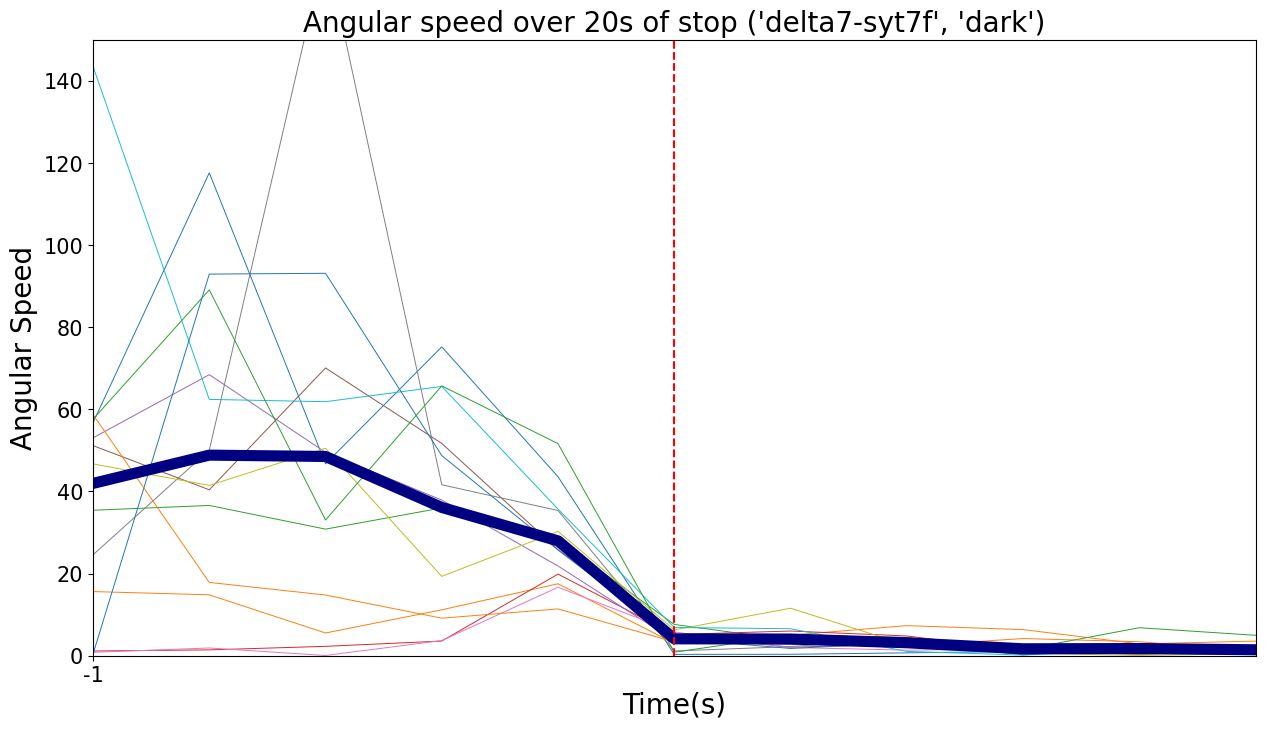

In [89]:
time_array_decay = np.arange(len(output_Angular_speed_pooled.mean(axis=1)))/5
plt.figure(figsize=(15,8))
for i in range(len(output_Angular_speed_pooled.columns)):
    plt.plot(time_array_decay,output_Angular_speed_pooled[i],linewidth = 0.7)
plt.plot(time_array_decay,output_Angular_speed_pooled.mean(axis=1), linewidth=8, color = 'navy')
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0,2)
plt.ylim(0,150)
plt.axvline(x= 1, color = 'r',linestyle ='--')
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Angular Speed', fontsize=20)
plt.title(f"Angular speed over {bump_amplitude_stopping_duration}s of stop {celltype, trial_condition}",fontsize =20)
plt.show()


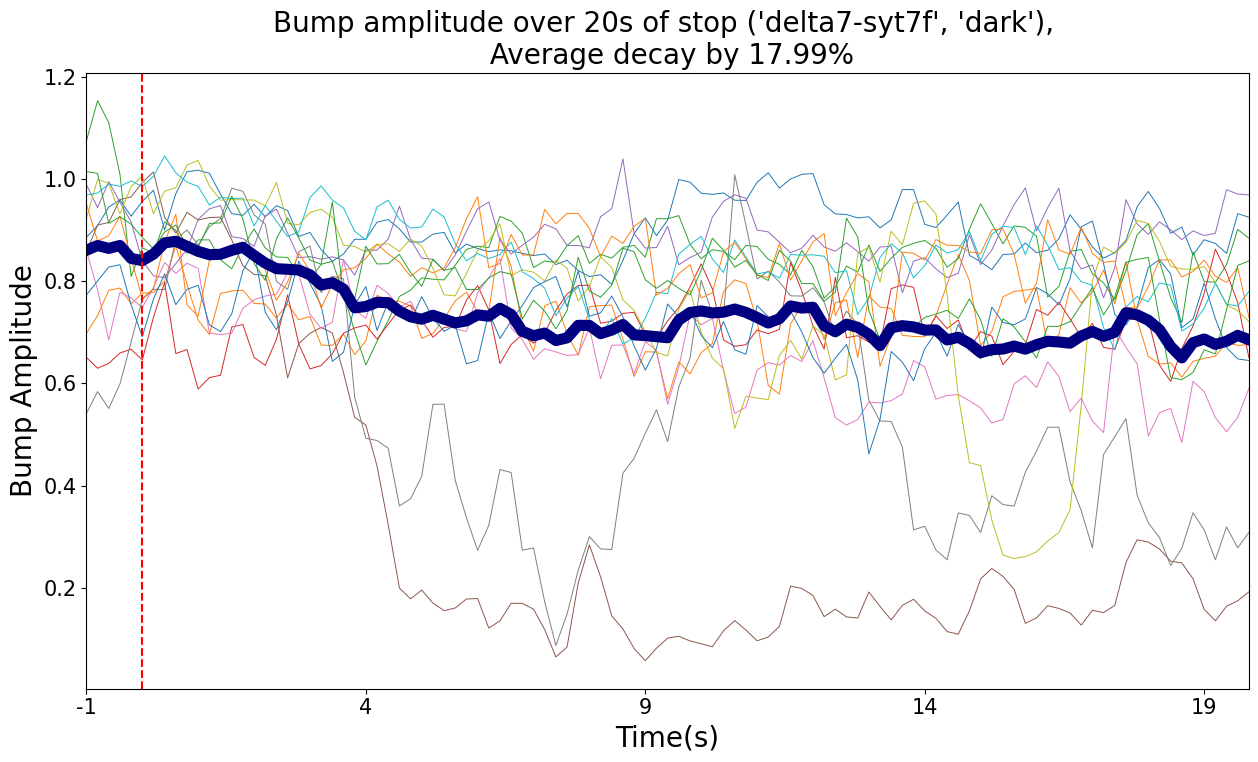

In [90]:
plot_stopping_period_signal(output_bump_amplitude_V4_pooled,stopping_bin_size_s=bump_amplitude_stopping_bin_size,decay_start_from_exact_stop=1,decay_length_s=bump_amplitude_stopping_duration ,active_period_length_s=active_period_before_len,run_spline_fit=False,celltype=celltype, trial_condition=trial_condition)

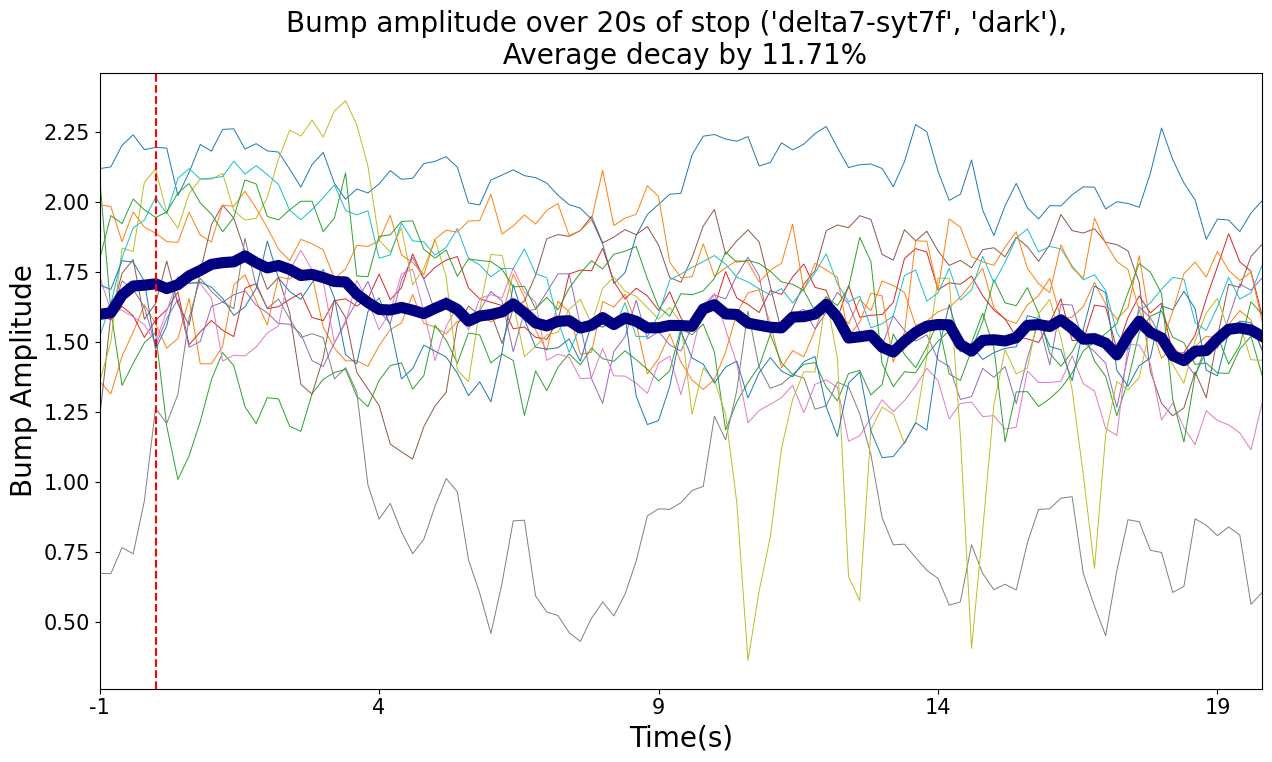

In [91]:
plot_stopping_period_signal(output_PVA_strength_pooled ,stopping_bin_size_s=bump_amplitude_stopping_bin_size,decay_start_from_exact_stop=1,decay_length_s=bump_amplitude_stopping_duration ,active_period_length_s=active_period_before_len,run_spline_fit=False,celltype=celltype, trial_condition=trial_condition)

In [92]:
fly_list = np.array(list(set(output_flytrial)))

In [93]:
Bump_amp_V3_stable = pd.DataFrame()
Bump_amp_V3_unstable = pd.DataFrame()
Bump_amp_V3_opposite_stable = pd.DataFrame()
Bump_amp_V3_opposite_unstable = pd.DataFrame()
for i in range(len(output_stable_PVA_index_pooled)):
    if output_stable_PVA_index_pooled[i] == 0:
        if i == 0:
            Bump_amp_V3_unstable = output_bump_amplitude_V3_pooled[i]
            Bump_amp_V3_opposite_unstable = output_bump_amplitude_V3_opposite_pooled[i]
        else:
            Bump_amp_V3_unstable = pd.concat([Bump_amp_V3_unstable,output_bump_amplitude_V3_pooled[i]],ignore_index=True, axis =1)
            Bump_amp_V3_opposite_unstable = pd.concat([Bump_amp_V3_opposite_unstable,output_bump_amplitude_V3_opposite_pooled[i]],ignore_index=True, axis =1)
    else:
        if i == 0:
            Bump_amp_V3_stable = output_bump_amplitude_V3_pooled[i]
            Bump_amp_V3_opposite_stable = output_bump_amplitude_V3_opposite_pooled[i]
        else:
            Bump_amp_V3_stable = pd.concat([Bump_amp_V3_stable,output_bump_amplitude_V3_pooled[i]],ignore_index=True, axis =1)
            Bump_amp_V3_opposite_stable = pd.concat([Bump_amp_V3_opposite_stable,output_bump_amplitude_V3_opposite_pooled[i]],ignore_index=True, axis =1)

In [80]:
output_bump_amplitude_V3_pooled_average_by_fly = calculate_stop_signal_in_separate_fly(output_bump_amplitude_V3_pooled,flylist = fly_list,trial_list=output_flytrial,stability_list=output_stable_PVA_index_pooled, separate_stableY_N=0)
output_bump_amplitude_V4_pooled_average_by_fly = calculate_stop_signal_in_separate_fly(output_bump_amplitude_V4_pooled,flylist = fly_list,trial_list=output_flytrial,stability_list=output_stable_PVA_index_pooled, separate_stableY_N=0)

In [13]:
#output_bump_amplitude_V3_pooled_average_by_fly.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/data/dark_average_by_fly/output_bump_amplitude_V3_pooled_averagebyfly_delta7_iGlu_PB_cl.csv',encoding = 'utf-8', index=False)
#output_bump_amplitude_V4_pooled_average_by_fly.to_csv('/home/tianhaoqiu/Pictures/Screenshots/analysis_12_2023/data/dark_average_by_fly/output_bump_amplitude_V4_pooled_averagebyfly_delta7_iGlu_PB_cl.csv',encoding = 'utf-8', index=False)

In [157]:
pooled_decay_df= pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/Average_Bump_amplitude_V3_decay_20s.csv')
#pooled_decay_stable_df= pd.read_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/Average_Bump_amplitude_V4_decay_20s.csv')
new_column_names = [0,1,2,3,4,5,6,7,8]
pooled_decay_df.columns = new_column_names

In [136]:
palette = sns.color_palette("dark", len(pooled_decay_stable_df.columns))

a =plt.figure(figsize=(20, 8))

for i in range(len(pooled_decay_stable_df.columns)):
    if i == 6:
        #plt.plot(time_array_decay, pooled_decay_stable_df[i], linewidth=5, color='green')
        plt.plot(time_array_decay, gaussian_filter1d(pooled_decay_stable_df[i], sigma=3), linewidth=5, color='green')
    elif i == 7:
        plt.plot(time_array_decay, gaussian_filter1d(pooled_decay_stable_df[i],sigma=3), linewidth=5, color='red')
    else:
        #plt.plot(time_array_decay, pooled_decay_stable_df[i], linewidth=3, color=palette[i])
        plt.plot(time_array_decay, gaussian_filter1d(pooled_decay_stable_df[i],sigma=3), linewidth=3, color=palette[i])
#plt.plot(time_array_decay, Bump_amp_V3_stable.mean(axis=1), linewidth=3, color='red')
#plt.plot(time_array_decay, gaussian_filter1d(Bump_amp_V3_stable.mean(axis=1),sigma=3), linewidth=3, color='red')


# Add custom labels and legend
custom_labels = ['E-PG-PB', 'E-PG-EB', 'P-EG-PB', 'P-EG-EB', 'P-EN2-PB', 'P-EN2-EB', 'delta7-PB','delta7-iGlu','PFNd-FB']
plt.legend(custom_labels, fontsize=15)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]-active_period_before_len, dtype=np.int64), fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,bump_amplitude_stopping_duration+0.8)
plt.axvline(x= 1, color = 'r',linestyle ='--',linewidth=2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Amplitude', fontsize=25)
plt.title(f"Average Bump amplitude (PVA) decay over {bump_amplitude_stopping_duration}s of  stop",fontsize =30)
plt.show()
#a.savefig('Bump_abplitude_at_PVA_stable_dark', format ='svg')

NameError: name 'pooled_decay_stable_df' is not defined

In [129]:
output_df_pooled.columns

Index(['FlyTrial', 'Genotype', 'TrialType', 'Period_duration',
       'PVA_before_stop', 'PVA_at_restart', 'PVA_100ms_before_restart',
       'PVA_500ms_before_restart', 'PVA_in_middle', 'PVA_2s_before_restart',
       'PVA_3s_after_stop', 'PVA_5s_after_stop', 'PVA_10s_after_stop',
       'PVA_20s_after_stop', 'PVA_35s_after_stop', 'PVA_60s_after_stop',
       'forward_speed_before_stop', 'forward_speed_at_restart',
       'forward_speed_100ms_before_restart',
       'forward_speed_500ms_before_restart', 'forward_speed_in_middle',
       'forward_speed_2s_before_restart', 'forward_speed_3s_after_stop',
       'forward_speed_5s_after_stop', 'forward_speed_10s_after_stop',
       'forward_speed_20s_after_stop', 'forward_speed_35s_after_stop',
       'bump_amplitude_before_stop', 'bump_amplitude_at_restart',
       'bump_amplitude_100ms_before_restart',
       'bump_amplitude_500ms_before_restart', 'bump_amplitude_in_middle',
       'bump_amplitude_2s_before_restart', 'bump_amplitude_3s_a

In [130]:
output_df_pooled['angle difference start/10s'] = np.abs(calculate_angle_difference_between_two_time_point(output_df_pooled['PVA_before_stop'],output_df_pooled['PVA_10s_after_stop']))
output_df_pooled['angle difference start/20s'] = np.abs(calculate_angle_difference_between_two_time_point(output_df_pooled['PVA_before_stop'],output_df_pooled['PVA_20s_after_stop']))

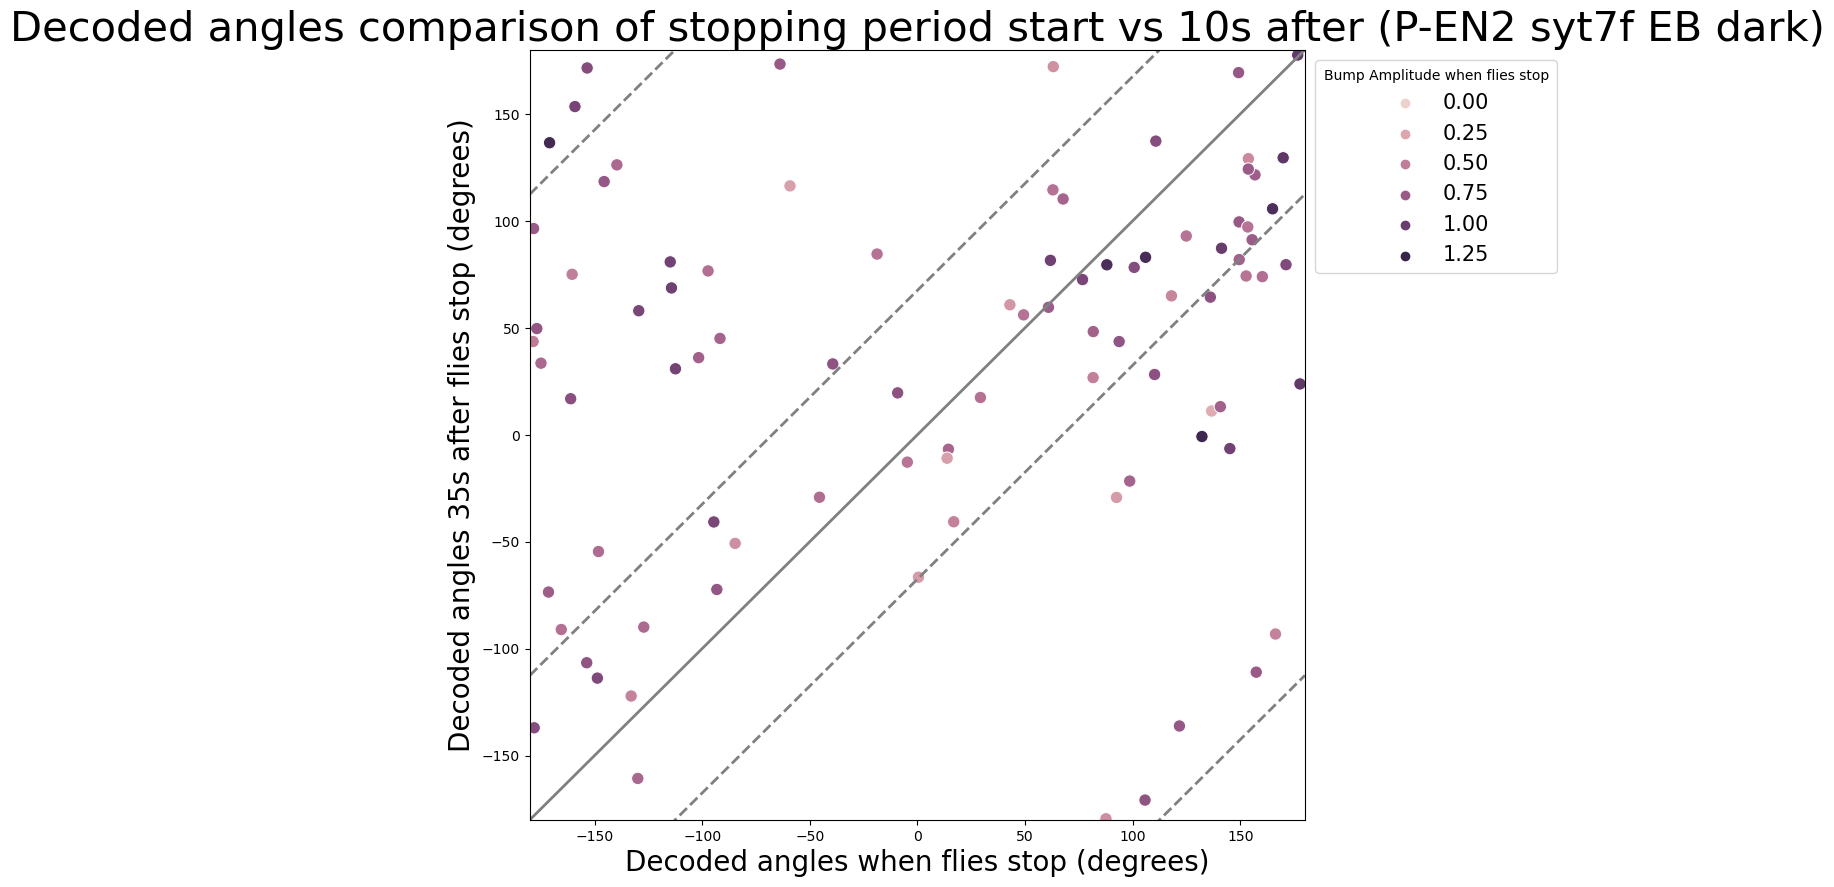

In [134]:
a = plt.figure(figsize= (10,10))
cmap = sns.cubehelix_palette(rot = -.2, as_cmap = True)
snsplot = sns.scatterplot(data = output_df_pooled, x='PVA_before_stop', y='PVA_10s_after_stop', hue = 'bump_amplitude_before_stop', s =80)
snsplot.legend(bbox_to_anchor= (1,1), title = 'Bump Amplitude when flies stop', fontsize = 15)
X_plot = np.linspace(-180, 180, 100)
Y_plot = X_plot
plt.plot(X_plot,Y_plot, color='grey', linewidth =2)
plt.plot(X_plot,Y_plot + 67.5, color='grey', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 67.5, color='grey', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot + 292.5, color='grey', linestyle ='--', linewidth =2)
plt.plot(X_plot,Y_plot - 292.5, color='grey', linestyle ='--', linewidth =2)
plt.ylim(-180, 180)
plt.xlim(-180, 180)
plt.title('Decoded angles comparison of stopping period start vs 10s after (P-EN2 syt7f EB dark)', fontsize =30)
plt.ylabel('Decoded angles 35s after flies stop (degrees)',fontsize= 20)
plt.xlabel('Decoded angles when flies stop (degrees)',fontsize= 20)
#plt.setp(snsplot.get_legend().get_texts(), fontsize = 10)
#plt.grid()
plt.show()
#a.savefig('PEN-2_syt7f_EB_Bump_Angle_10s_after_dark', format ='svg')

In [70]:
from matplotlib.cm import ScalarMappable


output_df_pooled_cleaned = output_df_pooled.dropna(subset=['angle difference start/20s', 'PVA_strength_20s_after_stop'])
# Create a scatter plot with the 'viridis' colormap
plt.figure(figsize=(8, 5))
scatter = sns.scatterplot(
    data=output_df_pooled_cleaned,
    x='angle difference start/20s',
    y='PVA_strength_20s_after_stop',
    s=80,
    #cmap='plasma',
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

# Customize labels and title
plt.xlabel('Angle Difference (start vs 20s)', fontsize=14)
plt.ylabel('PVA strength 20s After Stop', fontsize=14)
plt.title(f'{celltype}: Stop and 20s later Angle Difference vs. PVA strength', fontsize=16)


# Fit a linear regression model
regression_model = LinearRegression()
X = output_df_pooled_cleaned[['angle difference start/20s']]
y = output_df_pooled_cleaned['PVA_strength_20s_after_stop']
regression_model.fit(X, y)

sns.regplot(
    x='angle difference start/20s',
    y='PVA_strength_20s_after_stop',
    data=output_df_pooled_cleaned,
    scatter=False,  # To remove individual data points from the regression plot
    ax=scatter.axes  # Use the same axes as the scatter plot
)


# Get R-squared value
y_pred = regression_model.predict(X)
r_squared = r2_score(y, y_pred)

# Display R-squared value on the plot
#plt.text(0.5, 0.95, f'R-squared: {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='center')


#Calculate Spearman correlation coefficient
spearman_corr, _ = spearmanr(output_df_pooled_cleaned['angle difference start/20s'], output_df_pooled_cleaned['PVA_strength_20s_after_stop'])
# Display Spearman correlation coefficient on the plot
plt.text(0.5, 0.9, f'Spearman Correlation: {spearman_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='left')


# Create a ScalarMappable for colorbar
sm = ScalarMappable(cmap='viridis')
sm.set_array([])  # You need to set an array for the ScalarMappable


# Show the plot
plt.show()

KeyError: ['angle difference start/20s']

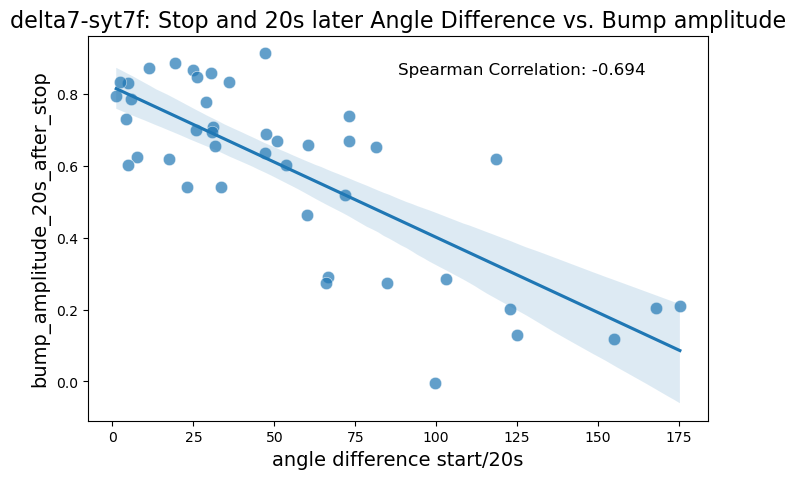

In [57]:
# Create a scatter plot with the 'viridis' colormap
output_df_pooled_cleaned = output_df_pooled.dropna(subset=['angle difference start/20s', 'bump_amplitude_20s_after_stop'])
plt.figure(figsize=(8, 5))
scatter = sns.scatterplot(
    data=output_df_pooled_cleaned,
    x='angle difference start/20s',
    y='bump_amplitude_20s_after_stop',
    s=80,
    #cmap='plasma',
    alpha=0.7,
    edgecolor='w',
    linewidth=0.5
)

# Customize labels and title
plt.xlabel('Angle Difference (start vs 20s)', fontsize=14)
plt.ylabel('Bump amplitude 20s After Stop', fontsize=14)
plt.title(f'{celltype}: Stop and 20s later Angle Difference vs. Bump amplitude', fontsize=16)


# Fit a linear regression model
regression_model = LinearRegression()
X = output_df_pooled_cleaned[['angle difference start/20s']]
y = output_df_pooled_cleaned['bump_amplitude_20s_after_stop']
regression_model.fit(X, y)


sns.regplot(
    x='angle difference start/20s',
    y='bump_amplitude_20s_after_stop',
    data=output_df_pooled,
    scatter=False,  # To remove individual data points from the regression plot
    ax=scatter.axes  # Use the same axes as the scatter plot
)


# Get R-squared value
y_pred = regression_model.predict(X)
r_squared = r2_score(y, y_pred)

# Calculate Pearson correlation coefficient
spearman_corr, _ = spearmanr(output_df_pooled_cleaned['angle difference start/20s'], output_df_pooled_cleaned['bump_amplitude_20s_after_stop'])

# Display R-squared value on the plot
#plt.text(0.5, 0.95, f'R-squared: {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='center')

# Display Pearson correlation coefficient on the plot
plt.text(0.5, 0.9, f'Spearman Correlation: {spearman_corr:.3f}', transform=plt.gca().transAxes, fontsize=12, ha='left')

# Create a ScalarMappable for colorbar
sm = ScalarMappable(cmap='viridis')
sm.set_array([])  # You need to set an array for the ScalarMappable


# Show the plot
plt.show()

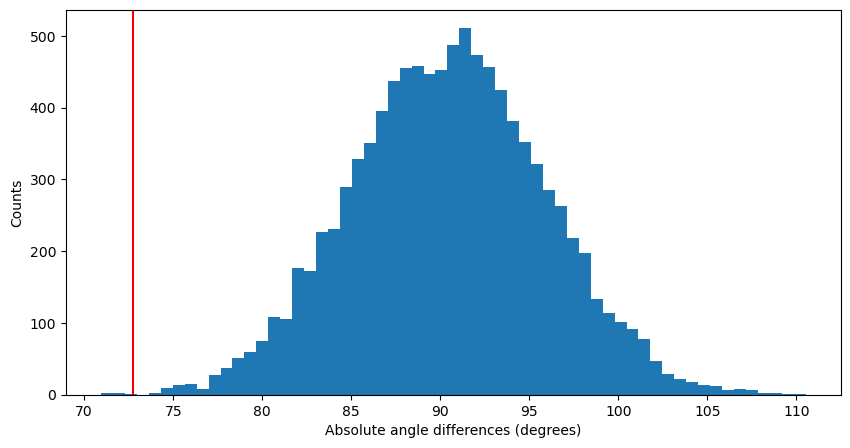

In [147]:
dark_stop_period_start_20s = np.zeros(len(np.argwhere(np.isnan(output_df_pooled['PVA_10s_after_stop'])==0)))
dark_stop_period_end_20s = np.zeros(len(np.argwhere(np.isnan(output_df_pooled['PVA_10s_after_stop'])==0))) 
long_trial_index = np.argwhere(np.isnan(output_df_pooled['PVA_10s_after_stop'])==0)
for i in range(len(dark_stop_period_start_20s )):
    dark_stop_period_start_20s[i] = output_df_pooled['PVA_before_stop'][long_trial_index[i][0]]
    dark_stop_period_end_20s[i] =  output_df_pooled['PVA_10s_after_stop'][long_trial_index[i][0]]
## Pilot code for boot stramping paired angle difference between start and end of the stopping period

#initialize a bootstrap array
bootstrap_mean_angle_differences_10000 = np.zeros(10000)
#size of each sampling 
pair_num = len(dark_stop_period_start_20s)

for i in range(len(bootstrap_mean_angle_differences_10000)):
    random_stop_start_angle = np.random.choice(dark_stop_period_start_20s,size = pair_num)
    random_stop_end_angle = np.random.choice(dark_stop_period_end_20s,size = pair_num)
    angle_difference = calculate_angle_difference_between_two_time_point(random_stop_start_angle,random_stop_end_angle)
    bootstrap_mean_angle_differences_10000[i] = np.mean(np.abs(angle_difference))   

actual_mean_absolute_angle_diff_dark_diff =  calculate_angle_difference_between_two_time_point(dark_stop_period_start_20s ,dark_stop_period_end_20s)
actual_mean_absolute_angle_diff_dark = np.mean(np.abs(actual_mean_absolute_angle_diff_dark_diff))
actual_mean_absolute_angle_diff_dark     

a = plt.figure(figsize=(10, 5))
plt.hist(bootstrap_mean_angle_differences_10000 ,bins='auto')
plt.axvline(x = actual_mean_absolute_angle_diff_dark, color = 'r')
plt.xlabel('Absolute angle differences (degrees)')
plt.ylabel('Counts')
plt.show()
a.savefig('PEN-2_syt7f_EB_Shuffle_analysos_Bump_Angle_10s_after_dark', format ='svg')

In [148]:
len(np.argwhere(np.isnan(output_df_pooled['PVA_60s_after_stop'])==0))

1

In [149]:
actual_mean_absolute_angle_diff_dark     

72.74270705607461

In [158]:
np.percentile(bootstrap_mean_angle_differences_10000, 0.038)

72.71100292216448

In [11]:
pooled_bump_amplitude_V4_allGenotypes_df= pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/darkcl imaging bump decay/v4/pooled_bump_amplitude_v4.csv')

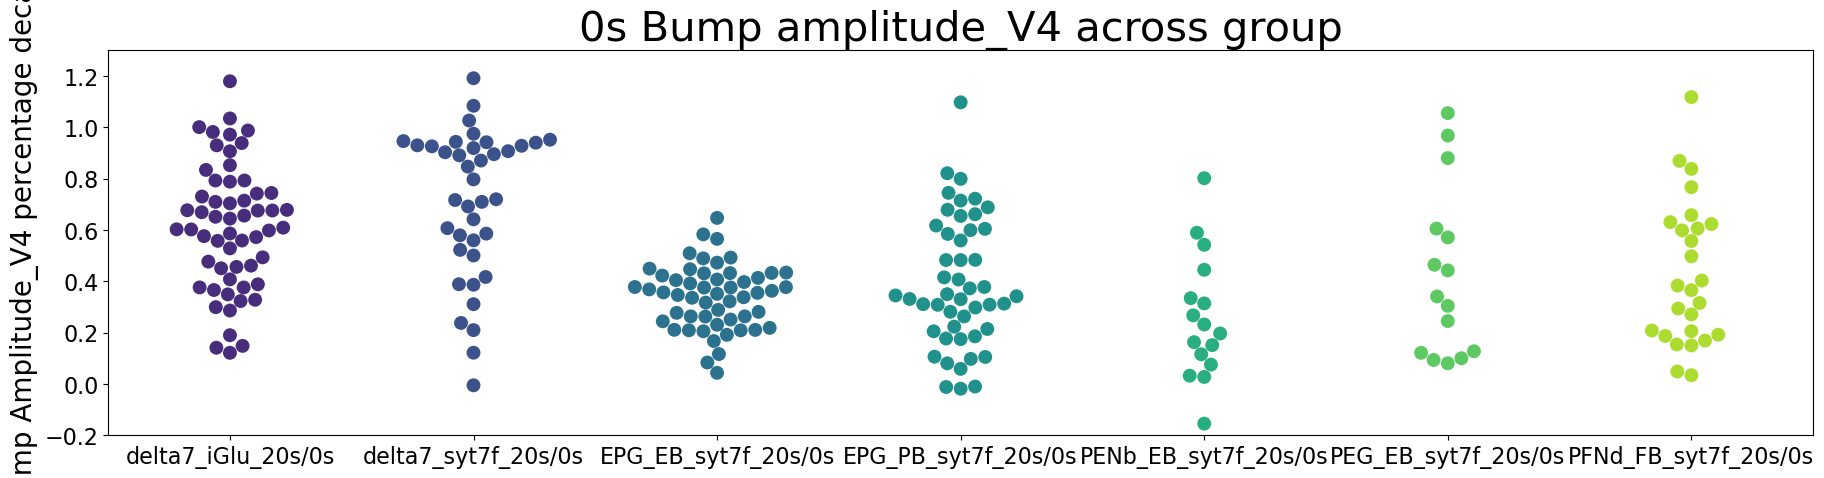

In [15]:

pooled_bump_amplitude_V4_allGenotypes_df

columns_to_plot_v4_percentage_20s = ['delta7_iGlu_20s/0s', 'delta7_syt7f_20s/0s','EPG_EB_syt7f_20s/0s','EPG_PB_syt7f_20s/0s', 'PENb_EB_syt7f_20s/0s', 'PEG_EB_syt7f_20s/0s','PFNd_FB_syt7f_20s/0s']


# Create a swarm plot
plt.figure(figsize=(22, 5))
sns.swarmplot(data=pooled_bump_amplitude_V4_allGenotypes_df[columns_to_plot_v4_percentage_20s ], palette='viridis', size=10)

plt.title('0s Bump amplitude_V4 across group', fontsize = 30)
plt.ylabel('Bump Amplitude_V4 percentage decat',fontsize =20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(-0.2,1.3)
plt.show()

In [16]:
run_ANOVA_for_comparing_across_genotypes(pooled_bump_amplitude_V4_allGenotypes_df,columns_to_plot_v4_percentage_20s)

One-way ANOVA Result:
F-statistic: 13.962474353592452
p-value: 1.1188452538118769e-13
Adjusted df between: 6
Adjusted df within: 248
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1               group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------
 EPG_EB_syt7f_20s/0s  EPG_PB_syt7f_20s/0s   0.0547 0.9298 -0.0942 0.2036  False
 EPG_EB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0869 0.9005 -0.1317 0.3054  False
 EPG_EB_syt7f_20s/0s PENb_EB_syt7f_20s/0s  -0.0815 0.9162 -0.2947 0.1317  False
 EPG_EB_syt7f_20s/0s PFNd_FB_syt7f_20s/0s   0.1274 0.3303 -0.0493 0.3041  False
 EPG_EB_syt7f_20s/0s   delta7_iGlu_20s/0s   0.2723    0.0  0.1297 0.4149   True
 EPG_EB_syt7f_20s/0s  delta7_syt7f_20s/0s   0.3708    0.0  0.2131 0.5285   True
 EPG_PB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0322 0.9995 -0.1889 0.2532  False
 EPG_PB_syt7f_20s/0s PENb_EB_syt7f_20s/0s  -0.1362 0.4973  -0.352 0

In [19]:
pooled_bump_amplitude_V4_allGenotypes_byfly_df= pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/darkcl imaging bump decay/v4/pooled_bump_amplitude_v4_averagebyfly_dark.csv')

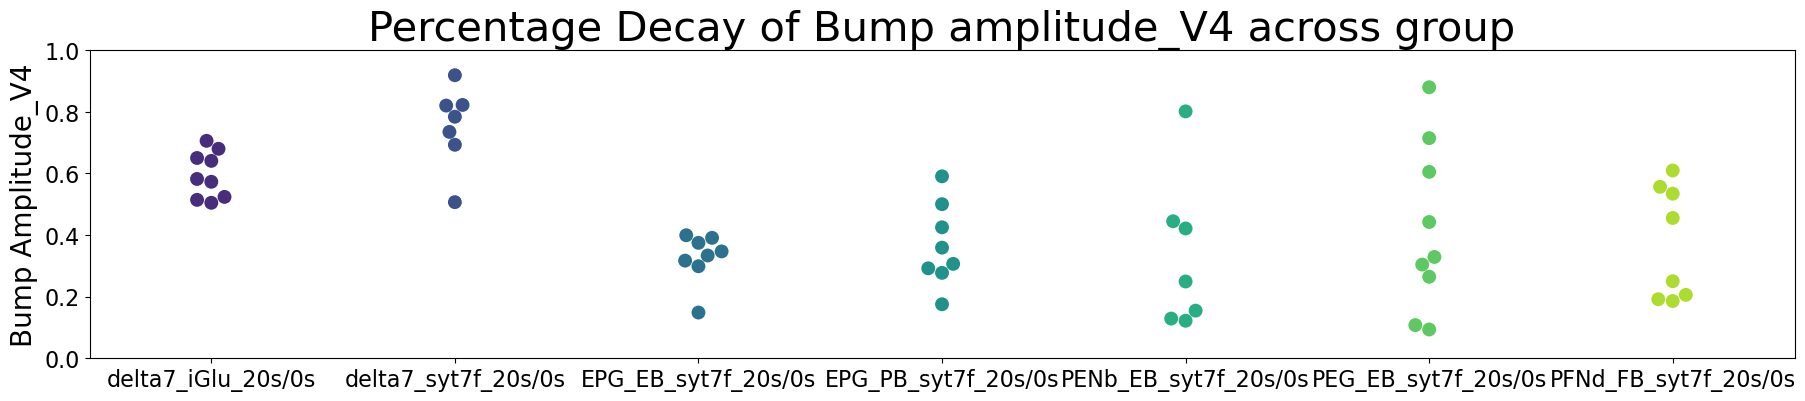

In [22]:
columns_to_plot_v4_percentage_20s_by_fly = ['delta7_iGlu_20s/0s', 'delta7_syt7f_20s/0s','EPG_EB_syt7f_20s/0s','EPG_PB_syt7f_20s/0s', 'PENb_EB_syt7f_20s/0s', 'PEG_EB_syt7f_20s/0s','PFNd_FB_syt7f_20s/0s']

# Create a swarm plot
plt.figure(figsize=(22, 4))
sns.swarmplot(data=pooled_bump_amplitude_V4_allGenotypes_byfly_df[columns_to_plot_v4_percentage_20s_by_fly ], palette='viridis', size=10)

plt.title('Percentage Decay of Bump amplitude_V4 across group', fontsize = 30)
plt.ylabel('Bump Amplitude_V4',fontsize =20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0,1)
plt.show()

In [23]:
run_ANOVA_for_comparing_across_genotypes(pooled_bump_amplitude_V4_allGenotypes_byfly_df,columns_to_plot_v4_percentage_20s_by_fly)

One-way ANOVA Result:
F-statistic: 6.4179827051628795
p-value: 4.882139037796809e-05
Adjusted df between: 6
Adjusted df within: 49
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1               group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------
 EPG_EB_syt7f_20s/0s  EPG_PB_syt7f_20s/0s   0.0396 0.9993 -0.2293 0.3084  False
 EPG_EB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0894 0.9387 -0.1718 0.3507  False
 EPG_EB_syt7f_20s/0s PENb_EB_syt7f_20s/0s   0.0055    1.0 -0.2728 0.2838  False
 EPG_EB_syt7f_20s/0s PFNd_FB_syt7f_20s/0s   0.0475  0.998 -0.2214 0.3163  False
 EPG_EB_syt7f_20s/0s   delta7_iGlu_20s/0s    0.271 0.0374  0.0098 0.5323   True
 EPG_EB_syt7f_20s/0s  delta7_syt7f_20s/0s   0.4282 0.0004  0.1499 0.7065   True
 EPG_PB_syt7f_20s/0s  PEG_EB_syt7f_20s/0s   0.0498 0.9969 -0.2114 0.3111  False
 EPG_PB_syt7f_20s/0s PENb_EB_syt7f_20s/0s  -0.0341 0.9998 -0.3123 0.2

In [47]:
pooled_PVA_strength_delta7_shi_df= pd.read_csv('/home/tianhaoqiu/Desktop/mean_PVA_strength_per_trial.csv')

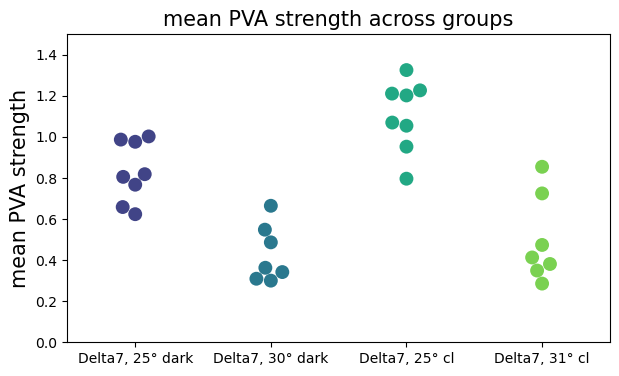

In [48]:
columns_to_plot_PVA_strength = ['Delta7, 25° dark', 'Delta7, 30° dark','Delta7, 25° cl','Delta7, 31° cl']


# Create a swarm plot
plt.figure(figsize=(7, 4))
sns.swarmplot(data=pooled_PVA_strength_delta7_shi_df[columns_to_plot_PVA_strength], palette='viridis', size=10)

plt.title('mean PVA strength across groups', fontsize = 15)
plt.ylabel('mean PVA strength',fontsize =15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0,1.5)
plt.show()

In [49]:
run_ANOVA_for_comparing_across_genotypes(pooled_PVA_strength_delta7_shi_df,columns_to_plot_PVA_strength)

One-way ANOVA Result:
F-statistic: 25.82005175722778
p-value: 5.8414032476720313e-08
Adjusted df between: 3
Adjusted df within: 26
          Multiple Comparison of Means - Tukey HSD, FWER=0.05           
     group1           group2      meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------
  Delta7, 25° cl Delta7, 25° dark  -0.2749 0.0156 -0.5067 -0.0432   True
  Delta7, 25° cl Delta7, 30° dark  -0.6744    0.0 -0.9142 -0.4345   True
  Delta7, 25° cl   Delta7, 31° cl  -0.6074    0.0 -0.8472 -0.3675   True
Delta7, 25° dark Delta7, 30° dark  -0.3994 0.0006 -0.6393 -0.1596   True
Delta7, 25° dark   Delta7, 31° cl  -0.3324 0.0041 -0.5723 -0.0926   True
Delta7, 30° dark   Delta7, 31° cl    0.067 0.8792 -0.1807  0.3147  False
------------------------------------------------------------------------


In [50]:
pooled_PVA_strength_glucl_df= pd.read_csv('/home/tianhaoqiu/Desktop/Analysis/60d05-glucl/60D05_glucl_mean_PVA_strength_per_fly.csv')

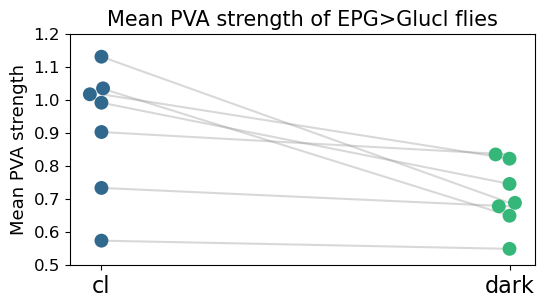

T-statistic: -3.237197374647247
P-value: 0.017749246362167615
Reject the null hypothesis; there is a significant difference between the groups.


In [59]:
from scipy.stats import ttest_rel

# Your list of columns
columns_to_plot_PVA_strength_glucl = ['cl', 'dark']

# Create a swarm plot
plt.figure(figsize=(6, 3))
ax = sns.swarmplot(data=pooled_PVA_strength_glucl_df[columns_to_plot_PVA_strength_glucl], palette='viridis', size=10)

# Connect corresponding dots with lines
for i in range(len(pooled_PVA_strength_glucl_df)):
    plt.plot([0, 1], pooled_PVA_strength_glucl_df.loc[i, columns_to_plot_PVA_strength_glucl].values, color='gray', alpha=0.3)

plt.title('Mean PVA strength of EPG>Glucl flies', fontsize=15)
plt.ylabel('Mean PVA strength', fontsize=13)
plt.xticks(fontsize=16)
plt.yticks(fontsize=12)
plt.ylim(0.5, 1.2)
plt.show()

# Perform paired sample t-test
t_statistic, p_value = ttest_rel(pooled_PVA_strength_glucl_df['dark'], pooled_PVA_strength_glucl_df['cl'])

# Display the results
print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

# Interpret the p-value
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis; there is a significant difference between the groups.")
else:
    print("Fail to reject the null hypothesis; there is no significant difference between the groups.")